<a href="https://colab.research.google.com/github/gracekflores/CECS456_Project/blob/main/CECS456_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Setting up environment
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import Callback
from google.colab import files
import pandas as pd

# Confirming GPU is active
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# Installing Kaggle API
!pip install kaggle

In [ ]:
# Uploading kaggle.json (API key)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "floresgracek",\r\n  "key": "KGAT_302fc7879223936f2b5cb07262ef57ec"\r\n}'}

In [ ]:
# Moving kaggle.json into the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dowloading the Chest X-Ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzipping into a folder called chest_xray
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [35]:
# --- Timer Callback ---
class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        self.times.append(epoch_time)
        print(f"  Epoch {epoch+1} took {epoch_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"\nTotal training time: {total_time:.2f} seconds")

# --- Building CNN Model ---
def build_model(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.005)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
                 metrics.Precision(name='precision'),
                 metrics.Recall(name='recall'),
                 metrics.AUC(name='auc_roc')]
    )
    return model

# --- Plot Training Curves ---
def plot_training_curves(history):
    plt.figure(figsize=(12,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [36]:
def plot_additional_metrics(history):
    plt.figure(figsize=(18, 5))

    # Precision
    plt.subplot(1, 3, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(1, 3, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    # AUC-ROC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc_roc'], label='Train AUC-ROC')
    plt.plot(history.history['val_auc_roc'], label='Val AUC-ROC')
    plt.title('Model AUC-ROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.tight_layout()
    plt.show()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,217 (16.36 MB)

 Trainable params: 4,288,513 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8019 - auc_roc: 0.8669 - loss: 2.1172 - precision: 0.9070 - recall: 0.8193  Epoch 1 took 77.41 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 433ms/step - accuracy: 0.8022 - auc_roc: 0.8672 - loss: 2.1138 - precision: 0.9071 - recall: 0.8197 - val_accuracy: 0.6250 - val_auc_roc: 0.5000 - val_loss: 3.1613 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8795 - auc_roc: 0.9345 - loss: 0.7744 - precision: 0.9151 - recall: 0.9237  Epoch 2 took 67.13 seconds
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.8795 - auc_roc: 0.9345 - loss: 0.7739 - precision: 0.9152 - recall: 0.9237 - val_accuracy: 0.6250 - val_auc_roc: 0.5000 - val_loss: 4.1550 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8836 - auc_roc: 0.9389 - loss: 0.6021 - precision: 0.9192 - recall: 0.9244  Epoch 3 took 66.89 seconds
163

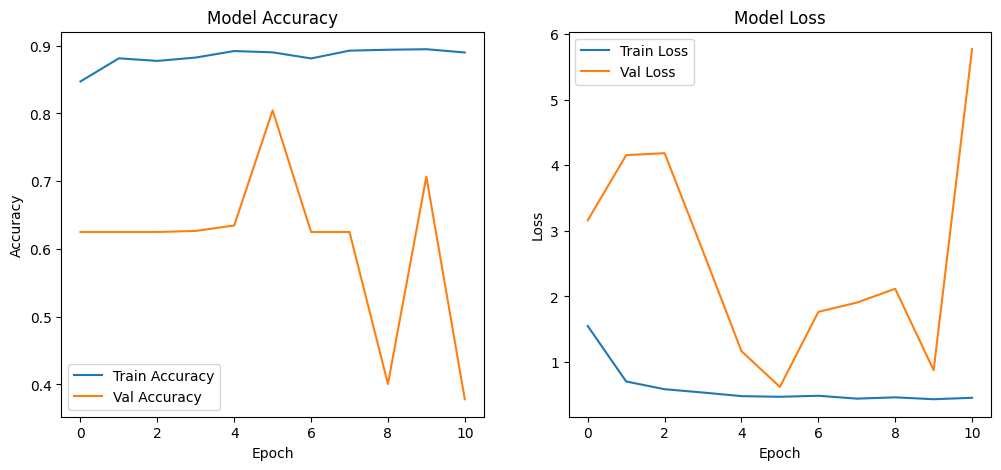

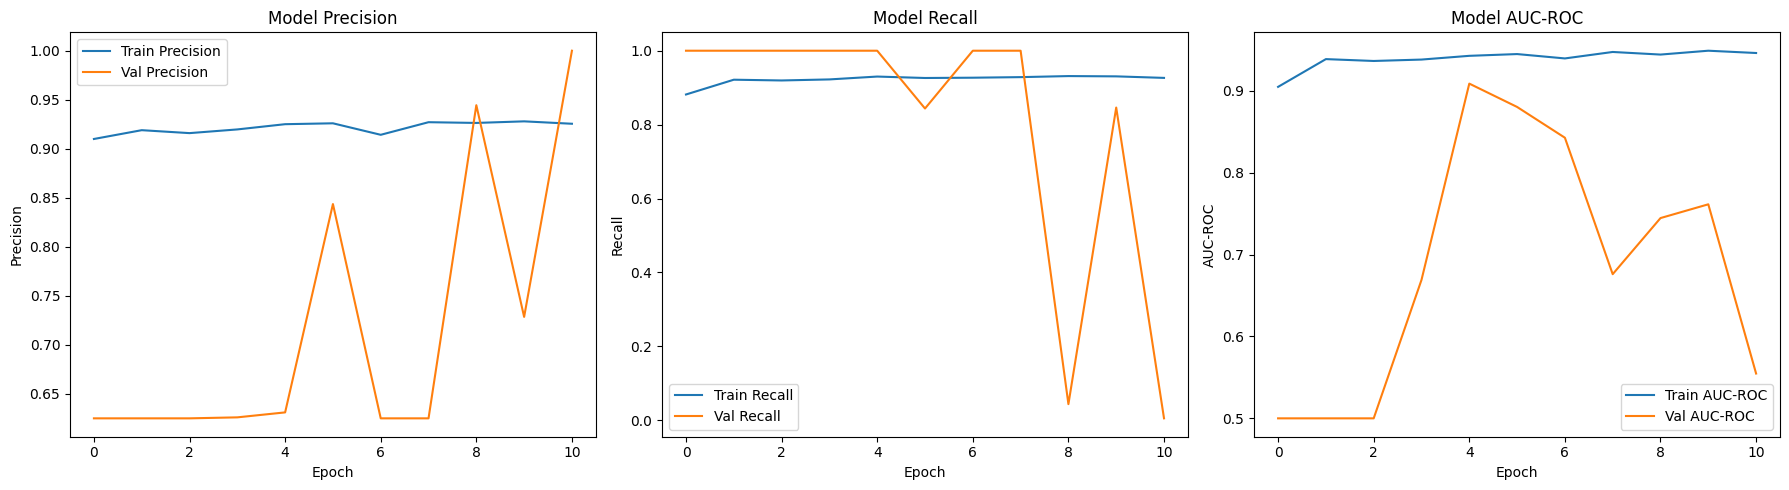

Model saved as cnn_model.keras


In [ ]:
# --- Main Execution ---
if __name__ == "__main__":
    IMG_WIDTH, IMG_HEIGHT = 128, 128
    BATCH_SIZE = 32

    TRAIN_DIR = '/content/chest_xray/chest_xray/train'
    VALIDATION_DIR = '/content/chest_xray/chest_xray/test' # Using 'test' as validation for better evaluation

    # Data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Loading data
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    # Building and training model
    model = build_model()
    model.summary()

    timing_callback = TimingCallback()
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=5,         # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[timing_callback, early_stopping_callback]
    )

    # Plotting training curves
    plot_training_curves(history)

    # Plotting the additional metrics
    plot_additional_metrics(history)

    # Saving trained model
    # model.save("cnn_model.keras")
    # print("Model saved as cnn_model.keras")

In [38]:
# Finding the epoch with the minimum validation loss
best_epoch_idx = history.history['val_loss'].index(min(history.history['val_loss']))
best_epoch = best_epoch_idx + 1 # Epochs are 1-indexed

# Extracting metrics for the best epoch
summary_data = {
    'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC-ROC'],
    'Train': [
        history.history['loss'][best_epoch_idx],
        history.history['accuracy'][best_epoch_idx],
        history.history['precision'][best_epoch_idx],
        history.history['recall'][best_epoch_idx],
        history.history['auc_roc'][best_epoch_idx]
    ],
    'Validation': [
        history.history['val_loss'][best_epoch_idx],
        history.history['val_accuracy'][best_epoch_idx],
        history.history['val_precision'][best_epoch_idx],
        history.history['val_recall'][best_epoch_idx],
        history.history['val_auc_roc'][best_epoch_idx]
    ]
}

# Creating a DataFrame
summary_df = pd.DataFrame(summary_data)

print(f"Summary of Model Performance at Best Epoch (Epoch {best_epoch}):")
display(summary_df)

Summary of Model Performance at Best Epoch (Epoch 6):


,Metric,Train,Validation
0,Loss,0.470107,0.620848
1,Accuracy,0.890146,0.804487
2,Precision,0.925955,0.843590
3,Recall,0.926194,0.843590
4,AUC-ROC,0.944826,0.880249
